In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin_cached_model as lcm
import pymc3 as pm
import scipy.io
import scipy as sp

In [5]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [6]:
from scipy.signal import butter, lfilter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [7]:
oxy_data37=scipy.io.loadmat('results/fMRI/OXY37_MRI_1_ts.mat')

mean:  -6.40646955775e-14
var:  43.9215908216
N:  736
relaxation time: 7.78708114601 SD tau 1.32177370795
A  43.6937491706 SD A 7.04802300876


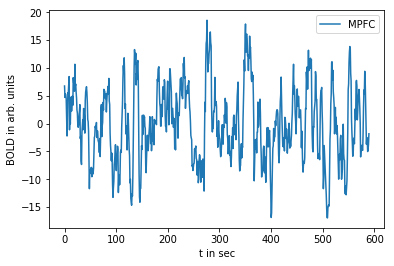

In [8]:
mpfc_r_ts=oxy_data37['mpfc_r_ts']
mpfc=np.mean(mpfc_r_ts,axis=0)
print("mean: ",mpfc.mean())
print("var: ",mpfc.std()**2)
N=len(mpfc)
print("N: ",N)
mpfc_A,mpfc_sA, mpfc_tau, mpfc_dtau = OUresult(mpfc,0.802)
print("relaxation time:",mpfc_tau, "SD tau", mpfc_dtau)
print("A ",mpfc_A,"SD A",mpfc_sA)
mpfc_norm=mpfc/np.sqrt(mpfc_A)
t = np.arange(N)*0.802 # tR = 0.802 sec
plt.plot(t,mpfc,label="MPFC")
plt.xlabel("t in sec")
plt.ylabel("BOLD in arb. units")
plt.legend()

mean:  -8.15965652533e-14
var:  36.788213768
N:  736
relaxation time: 8.86543894463 SD tau 1.58755740187
A  36.3481334973 SD A 6.22517691896
1.00603547113


Text(0,0.5,'BOLD in arb. units')

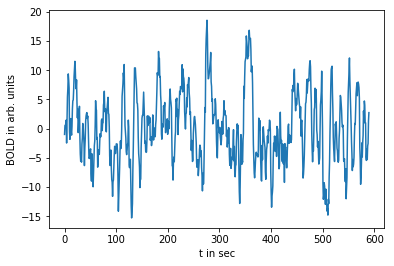

In [9]:
pcc_r_ts=oxy_data37['pcc_r_ts']
pcc=np.mean(pcc_r_ts,axis=0)
print("mean: ",pcc.mean())
print("var: ",pcc.std()**2)
N=len(pcc)
print("N: ",N)
pcc_A,pcc_sA, pcc_tau, pcc_dtau = OUresult(pcc,0.802)
print("relaxation time:",pcc_tau, "SD tau", pcc_dtau)
print("A ",pcc_A,"SD A",pcc_sA)
pcc_norm=pcc/np.sqrt(pcc_A)
print(pcc_norm.std())
plt.plot(t,pcc)
plt.xlabel("t in sec")
plt.ylabel("BOLD in arb. units")

mean:  -1.73831963317e-13
var:  13.3465095649
N:  736
relaxation time: 5.67436670013 SD tau 0.838877748428
A  13.2498924294 SD A 1.82818129535
1.00363933686


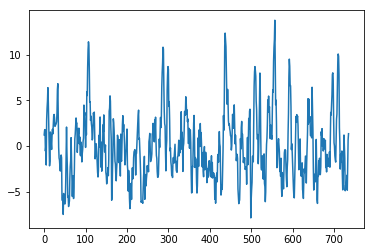

In [10]:
rlp_r_ts=oxy_data37['rlp_r_ts']
rlp=np.mean(rlp_r_ts,axis=0)
plt.plot(rlp)
print("mean: ",rlp.mean())
print("var: ",rlp.std()**2)
N=len(rlp)
print("N: ",N)
rlp_A,rlp_sA, rlp_tau, rlp_dtau = OUresult(rlp,0.802)
print("relaxation time:",rlp_tau, "SD tau", rlp_dtau)
print("A ",rlp_A,"SD A",rlp_sA)
rlp_norm=rlp/np.sqrt(rlp_A)
print(rlp_norm.std())

mean:  -1.19749620847e-13
var:  73.2901308929
N:  736
relaxation time: 9.45267995758 SD tau 1.7419126863
A  72.3979894218 SD A 12.7940312606
1.00614250393


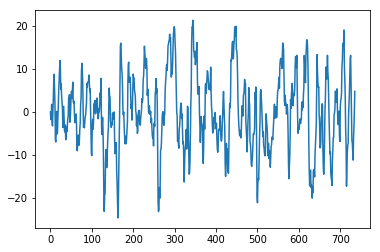

In [11]:
llp_r_ts=oxy_data37['llp_r_ts']
llp=np.mean(llp_r_ts,axis=0)
plt.plot(llp)
print("mean: ",llp.mean())
print("var: ",llp.std()**2)
N=len(llp)
print("N: ",N)
llp_A,llp_sA, llp_tau, llp_dtau = OUresult(llp,0.802)
print("relaxation time:",llp_tau, "SD tau", llp_dtau)
print("A ",llp_A,"SD A",llp_sA)
llp_norm=llp/np.sqrt(llp_A)
print(llp_norm.std())

In [12]:
def OUcross(data1,data2):
    x1 = data1 + data2
    x2 = data1 - data2
    x1_A,x1_dA, x1_tau ,x1_dtau= OUresult(x1,0.802)
    x2_A, x2_dA, x2_tau ,x2_dtau= OUresult(x2,0.802)
    return (x1_A - x2_A)/x2_A, np.sqrt(x1_dA**2 + x1_A**2*x2_dA**2/x2_A**4)
print("MPFC:PCC",OUcross(mpfc_norm,pcc_norm))
print("MPFC:RLP",OUcross(mpfc_norm,rlp_norm))
print("MPFC:LLP",OUcross(mpfc_norm,llp_norm))
print("PCC,RLP",OUcross(pcc_norm,rlp_norm))
print("PCC:LLP",OUcross(pcc_norm,llp_norm))
print("RLP:LLP",OUcross(rlp_norm,llp_norm))
print("Pearson MPFC:PCC",sp.stats.pearsonr(mpfc_norm,pcc_norm))
print("Pearson MPFC:RLP",sp.stats.pearsonr(mpfc_norm,rlp_norm))
print("Pearson MPFC:LLP",sp.stats.pearsonr(mpfc_norm,llp_norm))
print("Pearson PCC,RLP",sp.stats.pearsonr(pcc_norm,rlp_norm))
print("Pearson PCC:LLP",sp.stats.pearsonr(pcc_norm,llp_norm))
print("Pearson RLP:LLP",sp.stats.pearsonr(rlp_norm,llp_norm))

MPFC:PCC (11.273604431351139, 1.2409844302997832)
MPFC:RLP (0.88547184535466594, 0.48904065243856298)
MPFC:LLP (3.6658180185574856, 0.82973182439740201)
PCC,RLP (1.1425179125336959, 0.52824830501652398)
PCC:LLP (8.3504963108533001, 1.2568259808438322)
RLP:LLP (1.3270814515826381, 0.55701933725749753)
Pearson MPFC:PCC (0.85204248305578012, 1.6086021243831688e-208)
Pearson MPFC:RLP (0.3082331721002548, 1.156882428156865e-17)
Pearson MPFC:LLP (0.65152448405934049, 3.9376858303164667e-90)
Pearson PCC,RLP (0.36485753699043472, 1.3608756231821999e-24)
Pearson PCC:LLP (0.80838894596583688, 4.3197989875175176e-171)
Pearson RLP:LLP (0.39937825575932334, 1.4766553157037217e-29)


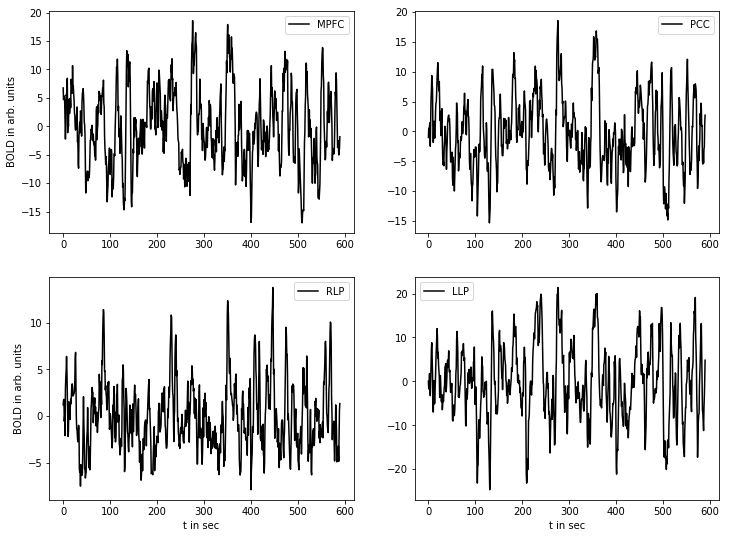

In [13]:
plt.figure(figsize=(12,9))
plt.subplot(2,2,1)
plt.plot(t,mpfc,"k",label="MPFC")
plt.ylabel("BOLD in arb. units")
plt.legend()
plt.subplot(2,2,2)
plt.plot(t,pcc,"k",label="PCC")
#plt.xlabel("t in sec")
#plt.ylabel("BOLD in arb. units")
plt.legend()
plt.subplot(2,2,3)
plt.plot(t,rlp,"k",label="RLP")
plt.xlabel("t in sec")
plt.ylabel("BOLD in arb. units")
plt.legend()
plt.subplot(2,2,4)
plt.plot(t,llp,"k",label="LLP")
plt.xlabel("t in sec")
#plt.ylabel("BOLD in arb. units")
plt.legend()


In [14]:
# lets filter the datasets and do this again
# Sample rate and desired cutoff frequencies (in Hz).
fs = 1/0.802
lowcut = 0.01
highcut = 0.08

relaxation time: 36.8005328592 SD tau 12.4047850194
A  27.455388645 SD A 9.15474819138


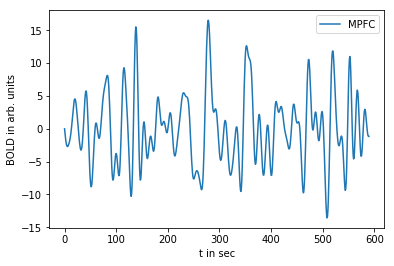

In [21]:
mpfc_filt = butter_bandpass_filter(mpfc, lowcut, highcut, fs, order=5)
mpfc_A,mpfc_sA, mpfc_tau, mpfc_dtau = OUresult(mpfc_filt,0.802)
print("relaxation time:",mpfc_tau, "SD tau", mpfc_dtau)
print("A ",mpfc_A,"SD A",mpfc_sA)
mpfc_norm=mpfc_filt/np.sqrt(mpfc_A)
plt.plot(t,mpfc_filt,label="MPFC")
plt.xlabel("t in sec")
plt.ylabel("BOLD in arb. units")
plt.legend()

relaxation time: 36.8198751247 SD tau 12.4389474136
A  23.5352640485 SD A 7.86475849613


Text(0,0.5,'BOLD in arb. units')

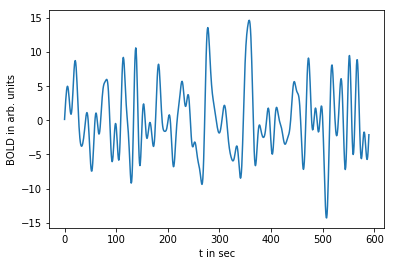

In [20]:
pcc_filt = butter_bandpass_filter(pcc, lowcut, highcut, fs, order=5)
pcc_A,pcc_sA, pcc_tau, pcc_dtau = OUresult(pcc_filt,0.802)
print("relaxation time:",pcc_tau, "SD tau", pcc_dtau)
print("A ",pcc_A,"SD A",pcc_sA)

pcc_norm=pcc_filt/np.sqrt(pcc_A)

plt.plot(t,pcc_filt)
plt.xlabel("t in sec")
plt.ylabel("BOLD in arb. units")

relaxation time: 39.6249811604 SD tau 13.9792552903
A  7.66098456578 SD A 2.67476024091


Text(0,0.5,'BOLD in arb. units')

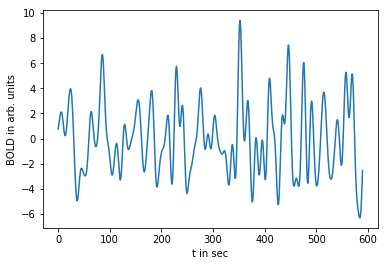

In [23]:
rlp_filt = butter_bandpass_filter(rlp, lowcut, highcut, fs, order=5)
rlp_A,rlp_sA, rlp_tau, rlp_dtau = OUresult(rlp_filt,0.802)
print("relaxation time:",rlp_tau, "SD tau", rlp_dtau)
print("A ",rlp_A,"SD A",rlp_sA)
rlp_norm=rlp_filt/np.sqrt(rlp_A)

plt.plot(t,rlp_filt)
plt.xlabel("t in sec")
plt.ylabel("BOLD in arb. units")

relaxation time: 36.375987377 SD tau 12.2245883292
A  47.497197353 SD A 15.7868261876


Text(0,0.5,'BOLD in arb. units')

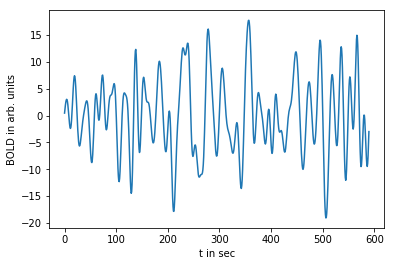

In [24]:
llp_filt = butter_bandpass_filter(llp, lowcut, highcut, fs, order=5)
llp_A,llp_sA, llp_tau, llp_dtau = OUresult(llp_filt,0.802)
print("relaxation time:",llp_tau, "SD tau", llp_dtau)
print("A ",llp_A,"SD A",llp_sA)

llp_norm=llp_filt/np.sqrt(llp_A)

plt.plot(t,llp_filt)
plt.xlabel("t in sec")
plt.ylabel("BOLD in arb. units")

In [25]:
print("MPFC:PCC",OUcross(mpfc_norm,pcc_norm))
print("MPFC:RLP",OUcross(mpfc_norm,rlp_norm))
print("MPFC:LLP",OUcross(mpfc_norm,llp_norm))
print("PCC,RLP",OUcross(pcc_norm,rlp_norm))
print("PCC:LLP",OUcross(pcc_norm,llp_norm))
print("RLP:LLP",OUcross(rlp_norm,llp_norm))
print("Pearson MPFC:PCC",sp.stats.pearsonr(mpfc_norm,pcc_norm))
print("Pearson MPFC:RLP",sp.stats.pearsonr(mpfc_norm,rlp_norm))
print("Pearson MPFC:LLP",sp.stats.pearsonr(mpfc_norm,llp_norm))
print("Pearson PCC,RLP",sp.stats.pearsonr(pcc_norm,rlp_norm))
print("Pearson PCC:LLP",sp.stats.pearsonr(pcc_norm,llp_norm))
print("Pearson RLP:LLP",sp.stats.pearsonr(rlp_norm,llp_norm))

MPFC:PCC (14.286834606220998, 5.5011161910362967)
MPFC:RLP (1.0831553400634384, 1.1685159859934602)
MPFC:LLP (4.5630700503509942, 2.1934110264043025)
PCC,RLP (1.6831486850440058, 1.3252399698784822)
PCC:LLP (9.3512828894997533, 3.7759152186035463)
RLP:LLP (1.6845669731550159, 1.3211882258214172)
Pearson MPFC:PCC (0.87674849309367064, 1.5369962054382319e-235)
Pearson MPFC:RLP (0.35827364095352926, 1.034058179462882e-23)
Pearson MPFC:LLP (0.69424161946828455, 6.231823443520903e-107)
Pearson PCC,RLP (0.46250773734720058, 2.7498936458460412e-40)
Pearson PCC:LLP (0.82202394535908052, 1.1476843334675591e-181)
Pearson RLP:LLP (0.46053076274869847, 6.4673086580855421e-40)


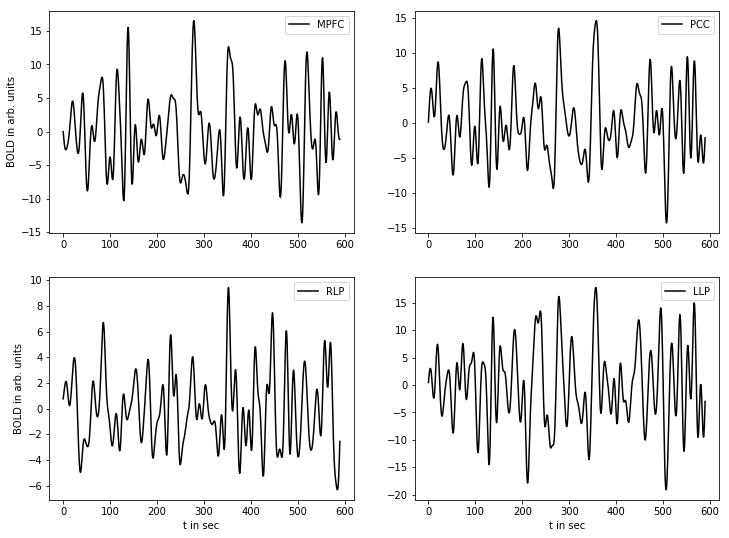

In [26]:
plt.figure(figsize=(12,9))
plt.subplot(2,2,1)
plt.plot(t,mpfc_filt,"k",label="MPFC")
plt.ylabel("BOLD in arb. units")
plt.legend()
plt.subplot(2,2,2)
plt.plot(t,pcc_filt,"k",label="PCC")
#plt.xlabel("t in sec")
#plt.ylabel("BOLD in arb. units")
plt.legend()
plt.subplot(2,2,3)
plt.plot(t,rlp_filt,"k",label="RLP")
plt.xlabel("t in sec")
plt.ylabel("BOLD in arb. units")
plt.legend()
plt.subplot(2,2,4)
plt.plot(t,llp_filt,"k",label="LLP")
plt.xlabel("t in sec")
#plt.ylabel("BOLD in arb. units")
plt.legend()
